In [1]:
import pandas as pd
import datetime
import seaborn as sbn
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
#event_location =
#event_date =


## The police dataset - onboarding and cleaning up
The SPD publishes a .csv of virtually all 911 calls (originating from both within and without the SPD), with the following columns:
* CAD event number
* Event Clearance Description
* Call Type
* Priority
* Initial Call Type
* Final Call Type
* Original Time Queued
* Arrived Time
* Precinct
* Sector
* Beat

For development, I'm using a download of the 911 calls. (For actual implementation, it is possible to download new data on demand as the tool is run, determining if the most recent entry date is within the date range used and downloading all entries  after that date and all non-redundant entries from that date.)

I'm dropping times from the dataframe as they're unneeded and converting the date strings to datetime. This conversion takes a non-trivial amount of time, hence the future plan to download only new data, convert, and add to the dataframe.


In [2]:
call_data = pd.read_csv('Call_Data.csv')

One of the reasons I abandoned the police report data was the amount of noise in the system - more reports are generated when more officer-hours are spent in a given beat. And I know that there are times when specific places are very heavily patrolled - see: cop towers in mall parking lot during the holidays. For that reason, I'm going to create a "Call Source" column with values "external" (TELEPHONE OTHER, NOT 911; 911; ALARM CALL (NOT POLICE ALARM); POLICE (VARDA) ALARM; IN PERSON COMPLAINT; and TEXT MESSAGE), "internal" (ONVIEW, PROACTIVE (OFFICER INITIATED), and SCHEDULED EVENT (RECURRING)), and "error" (HISTORY CALL (RETRO) and FK ERROR).

The primary data for examining changes in crime will be external calls. These can be compared to internal calls to see if my hypothesis is correct that most of the noise in the system is due to internal calls.

In [3]:
# Slicing out a test dataset for testing approaches on; closer to middle of df to assure it's "actual" not historical
call_data_test = call_data.iloc[2000000:2000100,:]

In [4]:
external_call_types_list = ["TELEPHONE OTHER, not 911", "911", "ALARM CALL (NOT POLICE ALARM)", "POLICE (VARDA ALARM)", "IN PERSON COMPLAINT", "TEXT MESSAGE"]
internal_call_types_list = ["ONVIEW", "PROACTIVE (OFFICER INITIATED)", "SCHEDULED EVENT (RECURRING)"]
def callSource(x):
    if x in internal_call_types_list:
        return "Internal"
    elif x in external_call_types_list:
        return "External"
    else:
        return "Other"

call_data_modified = call_data
# Appending the "Call Source" column to the dataframe based on the entries in "Call Type"
call_data_modified["Call Source"] = [callSource(entry) for entry in call_data.iloc[:,2]]
# Saving my work because the previous iteration-based attempt took half of forever
call_data_modified.to_csv('911 reports modified.txt', index=False, sep='\t')

There are too many final and initial call types (418 and 315, respectively) for the approach of binning crimes by type, as done with the police reports, to be a good investment of energy, at least without some evidence that this exercise will actually be useful.

Initial attempt to apply the previously-developed code from SPD-reports before-after shows that "Original Time Queued" is stored in the dataframe as a string. Thankfully, the format seems to be consistent?
MM/DD/YYYY HH:MM:SS AP
%m/%d/%Y  %l:%M:%S %p

In [5]:
import datetime

# Modified from JournalDev python string to datatime - strptime()
def timeConversion(x):
    try:
        # Converting string of set format to date only
        return datetime.datetime.strptime(x, '%m/%d/%Y %H:%M:%S %p').date()
    except ValueError as ve:
        try:
            # Converting with a slower function that can deal with variations in format to a certain extent
            pd.to_datetime(x, dayfirst = False, yearfirst = False, infer_datetime_format = True)
        except ValueError as ve:
            print('ValueError Raised:', ve)


    
# Using timeConversion(x) to update all the entries for "Original Time Queued" in call_data
call_data.iloc[:,6] = call_data.iloc[:,6].map(timeConversion)

## Changes in beats
One of the complications of using this dataset is that the most precise location is by beat, and beat boundaries have changed repeatedly over the years.

Crime data is noisy, particularly violent crime, since the numbers are relatively low. At a guess, a 90 day window is probably the minimum span where the signal-to-noise ratio is acceptable. Given that there are seasonal variations in all kinds of human data (and things like noise complaints are probably more prevalent in the summer), the default will be to compare the year prior to the given date and the year following the given date.

There have also been small changes to how precincts and sectors have been drawn, but precinct-level changes seem to be limited to the East and West Precincts for 2015.

Per the SPD Beats data, https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Beats/nnxn-434b, beats have been changed at 2008, 2015, and 2018. For the moment, comparisons that cross one of these date boundaries will throw a warning that data may be flawed as beat boundaries may have changed; with more time to research the history, analyses can be allowed or disallowed based on whether or not the boundaries of the beat in question changed at the particular time.

In [6]:
window = 90
event_date = datetime.date(2015, 4, 5)
event_location = "B2"
beat_changes = [datetime.date(2008, 1, 1), datetime.date(2015, 1, 1), datetime.date(2018, 1, 1)]
for entry in beat_changes:
    if abs(event_date - entry) < datetime.timedelta(days = window):
        print("CAUTION: Beats have changed during the window used; proceed with caution or compare by sector/precinct")
if event_date - datetime.timedelta(days = 90) < datetime.date(2009, 6, 2):
    print("First entry in call_data is 6 June 2009; adjust window or choose another event date.")

From the parent call_data set, a subset is constructed consisting of incidents within the query window of the date in question with sources "Internal" or "External".

In [7]:
start = event_date - datetime.timedelta(days = window)
end = event_date + datetime.timedelta(days = window)
within_window = call_data.loc[(call_data["Original Time Queued"] > start) & (call_data["Original Time Queued"] < end), ["CAD Event Number", "Call Source", "Original Time Queued", "Precinct", "Sector", "Beat"]].copy()
within_window

,CAD Event Number,Call Source,Original Time Queued,Precinct,Sector,Beat
39,2015000012300,Internal,2015-01-12,NORTH,UNION,U3
49,2015000063268,Internal,2015-02-24,EAST,CHARLIE,C2
53,2015000022493,External,2015-01-20,NORTH,UNION,U2
67,2015000037570,Other,2015-02-02,SOUTH,SAM,S3
68,2015000064472,External,2015-02-26,EAST,GEORGE,G1
...,...,...,...,...,...,...
4388629,2015000183976,Internal,2015-06-03,WEST,MARY,M1
4388690,2015000131975,Internal,2015-04-22,SOUTH,ROBERT,R1
4388691,2015000090777,External,2015-03-20,NORTH,UNION,U2
4388692,2015000094254,External,2015-03-23,WEST,QUEEN,Q2


## Getting rates

From the subset, we can get a count of crimes of each type, before and after the date in question, within and without the area in question.

The simplest comparison is to look at the percentage change in crime from the before to the after, comparing the within-beat change to the change for all other beats across the same time period.

Comparing crime from area to area is often done on #/standard population unit level, but the census data I found isn't easily applied to beats, and census data is going to be a bit squiffy when it comes to actual occupancy in areas not zoned for residences (i.e. lots of people work there during the day and a few people live there in their cars at night).

In [28]:
precinct = ["EAST", "NORTH", "SOUTH", "SOUTHWEST", "WEST", "UNKNOWN"]
sector = ["B", "C", "D", "E", "F", "G", "J", "K", "L", "M", "N", "O", "Q", "R", "S", "U", "W"]
beat = ["B1", "B2", "B3", "C1", "C2", "C3", "D1", "D2", "D3", "E1", "E2", "E3", "F1", "F2", "F3", "G1", "G2", "G3", "J1", "J2", "J3", "K1", "K2", "K3", "L1", "L2", "L3", "M1", "M2", "M3", "N1", "N2", "N3", "O1", "O2", "O3", "Q1", "Q2", "Q3", "R1", "R2", "R3", "S1", "S2", "S3", "U1", "U2", "U3", "W1", "W2", "W3"]

#Using sum to get count of entries that fit given parameters by location (geo_flag)
#geo_flag manually set to beat here, but future plan is to allow user to choose at onset, with beat being default
geo_flag = beat
all_before = [sum((within_window["Original Time Queued"] < event_date) & (within_window["Beat"] == entry)) for entry in geo_flag]
all_after = [sum((within_window["Original Time Queued"] >= event_date) & (within_window["Beat"] == entry)) for entry in geo_flag]
total = [(after-before)/(max(before, 1))*100 for before, after in zip(all_before, all_after)]

int_before = [sum((within_window["Original Time Queued"] < event_date) & (within_window["Beat"] == entry) & (within_window["Call Source"] == "Internal")) for entry in geo_flag]
int_after = [sum((within_window["Original Time Queued"] >= event_date) & (within_window["Beat"] == entry) & (within_window["Call Source"] == "Internal")) for entry in geo_flag]
internal = [(after-before)/(max(before, 1))*100 for before, after in zip(int_before, int_after)]

ext_before = [sum((within_window["Original Time Queued"] < event_date) & (within_window["Beat"] == entry) & (within_window["Call Source"] == "External")) for entry in geo_flag]
ext_after = [sum((within_window["Original Time Queued"] >= event_date) & (within_window["Beat"] == entry) & (within_window["Call Source"] == "External")) for entry in geo_flag]
external = [(after-before)/(max(before, 1))*100 for before, after in zip(ext_before, ext_after)]

oth_before = [sum((within_window["Original Time Queued"] < event_date) & (within_window["Beat"] == entry) & (within_window["Call Source"] == "Other")) for entry in geo_flag]
oth_after = [sum((within_window["Original Time Queued"] >= event_date) & (within_window["Beat"] == entry) & (within_window["Call Source"] == "Other")) for entry in geo_flag]
other = [(after-before)/(max(before, 1))*100 for before, after in zip(oth_before, oth_after)]

In [29]:
# Combining the lists of percentages into a single dataframe
percentages = pd.DataFrame({"beat": beat, "total": total, "internal": internal, "external": external, "other": other})
percentages

,beat,total,internal,external,other
0,B1,12.934716,-0.432900,19.335706,8.849558
1,B2,4.434072,2.352941,7.533414,1.257862
2,B3,19.123742,22.112211,11.727617,27.487352
3,C1,5.990134,-5.223881,17.110266,3.258656
4,C2,-8.786936,-29.323308,6.042885,-7.219251
5,C3,-5.494505,-44.642857,24.329502,11.497326
6,D1,15.522876,4.054054,12.269939,44.507042
7,D2,-1.656726,-7.578254,8.489209,5.776892
8,D3,-11.631140,-34.772727,3.708609,5.162524
9,E1,11.928651,-9.751434,21.635884,19.688109


Where's a particular beat relative to the whole, then? 

Text(0.5, 1.0, 'Percentage change in calls for 90 days after versus before 2015-04-05\nfor all beats (boxplot) and B2 (black dot)')

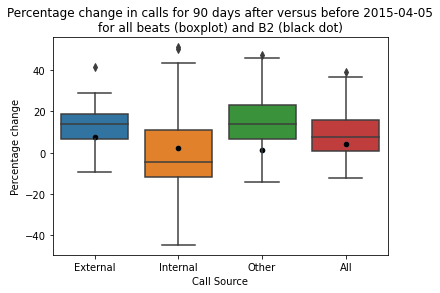

In [13]:
# Slice out beat of interest
beat_of_interest = percentages.loc[event_location, :]
# beat_of_interest transposed,shoved into a dataframe, & index reset so it can be used w/ dataframe.plot.scatter
beat_of_interest_frame = beat_of_interest.transpose().to_frame().reset_index()
beat_of_interest_frame.plot.scatter(x = "index", y = event_location)
# Initialize data_plot with box plot of percentage change for all beats
data_plot = sbn.boxplot(data = percentages)
# Scatter plot of only beat of interest on top of boxplot
beat_of_interest_frame.plot.scatter(x = "index", y = event_location, ax = data_plot, color = "black")
data_plot.set_xlabel("Call Source")
data_plot.set_ylabel("Percentage change")
data_plot.set_title("Percentage change in calls for " + str(window) + " days after versus before " + str(event_date) + "\nfor all beats (boxplot) and " + str(event_location) + " (black dot)")

What about visualization by location? After all, I'm always seeing shaded maps in /r/dataisbeautiful, so let's see how difficult it is to set that up.

Let's start by using geopandas. A necessary future improvement will be to have the program automatically pull the appropriate beat, but first I need to get to the basic visualization.

One critical issue is that the order of beats in the geodataframe doesn't match the order of beats I've been working with, and I have no reason to believe that beat order will be consistent across the shapefiles. For that reason, it makes sense to append the percentage change values to the geodataframe by calling the appropriate value from the percentage change dataframe. This kind of iteration is decidedly slow on dataframes in general, but we're also working with <100 entries, so it's not a real problem compared with reading in the data and assembling the within_window dataframe.

In [139]:
# Initializing geodataframe using shapefile
spd_beats_temp = gpd.read_file('Seattle_Police_Beats_2018-present.shp')
# Getting geodataframe into the same order as beat
spd_beats_temp.sort_values(by = "beat", inplace = True)
# Slicing out the "no beat" line
spd_beats = spd_beats_temp.iloc[1:, :]
spd_beats.to_file("beats2018-present.geojson", driver = "GeoJSON")

The beat maps are static, not dynamic, so there's no need to keep repeating the pull-edit-create process over and over. Instead, let's export the geodataframe to a file with a clear name, and do this for all four beat maps. Then, when this project is turned into a proper program, it can pull the beat map as appropriate.

In [22]:
# Repeating whole process for pre-2008 beats map
spd_beats_pre_08 = gpd.read_file('Seattle_Police_Beats_Pre-2008.shp')
spd_beats_pre_08.sort_values(by = "beat", inplace = True)
spd_beats_pre_08 = spd_beats_pre_08.iloc[1:, :]
spd_beats_pre_08.to_file("beatsPre2008.geojson", driver = "GeoJSON")

# Repeating whole process for 2008-2015 beats map
spd_beats_08_15 = gpd.read_file('Seattle_Police_Beats_2008-2015.shp')
spd_beats_08_15.sort_values(by = "beat", inplace = True)
spd_beats_08_15 = spd_beats_08_15.iloc[1:, :]
spd_beats_08_15.to_file("beats2008-2015.geojson", driver = "GeoJSON")
# Repeating whole process for 2015-2017 beats map
spd_beats_15_17 = gpd.read_file('Seattle_Police_Beats_2015-2017.shp')
spd_beats_15_17.sort_values(by = "beat", inplace = True)
spd_beats_15_17 = spd_beats_15_17.iloc[1:, :]
spd_beats_15_17.to_file("beats2015-2017.geojson", driver = "GeoJSON")

In [159]:
spd_beats.head()

,OBJECTID,beat,first_prec,sector,shape_Leng,shape_Area,geometry,coords
1,2,B1,N,B,30766.975027,3.888917e+07,"POLYGON ((-122.40539 47.67582, -122.40535 47.6...","(-122.38955645719263, 47.668304654209905)"
2,3,B2,N,B,32647.183464,5.514478e+07,"POLYGON ((-122.36620 47.67598, -122.36604 47.6...","(-122.36046831997409, 47.66142414472111)"
3,4,B3,N,B,36973.284197,5.961233e+07,"POLYGON ((-122.33800 47.66869, -122.33638 47.6...","(-122.33486442273961, 47.65776219082839)"
4,5,C1,E,C,37950.240898,3.255283e+07,"POLYGON ((-122.31277 47.61415, -122.31277 47.6...","(-122.31817896625253, 47.63340514413282)"
6,7,C2,E,C,38021.817035,6.727984e+07,"POLYGON ((-122.29936 47.64637, -122.29884 47.6...","(-122.29715597118113, 47.63145923778805)"


In [158]:
# Getting representative point (approx center) per https://stackoverflow.com/a/38902492/2880512
spd_beats['coords'] = spd_beats['geometry'].apply(lambda x: x.representative_point().coords[:])
# Converting shapely point object into tuple
spd_beats['coords'] = [coords[0] for coords in spd_beats['coords']]
# Manually dropping a marker onto the map to confirm that representative_point worked reasonably
#folium.Marker((47.661, -122.360),
#              folium.Tooltip(spd_beats.iloc[1, 2],)).add_to(mapviz)

In [191]:
# Code adapted from https://www.nagarajbhat.com/post/folium-visualization/
# Map centered on Seattle and zoomed appropriately for beats map
mapviz = folium.Map([47.6, -122.3], 
                    zoom_start = 11)
# Creating choropleth layer; note that since there are an even number of bins, the middle of the legend is the median. 
choropleth = folium.Choropleth(geo_data = spd_beats,
                              name = 'percentages shading',
                              data = percentages,
                              columns = ["beat", "external"],
                              key_on = 'properties.beat',
                               bins = 8,
                              fill_color = 'PuBuGn',
                               nan_fill_color = '#ffffff',
                               nan_fill_opacity = 0,
                              legend = 'Change in external calls compared to before event (percentage)'
                              ).add_to(mapviz)
folium.LayerControl(collapsed = True).add_to(mapviz)

In [158]:
# Adapting DivIcon code from https://github.com/python-visualization/folium/issues/340#issuecomment-179673692
from folium.features import DivIcon

In [192]:
for x in range(1, len(spd_beats)):
    folium.map.Marker([spd_beats.iloc[x, 7][1], 
                   spd_beats.iloc[x, 7][0]],
                 icon = DivIcon(
                     html = spd_beats.iloc[x, 1],
                    )).add_to(mapviz)

In [193]:
mapviz

It appears that calls originating outside SPD may be less variable than internal calls; if this were a tool I was building purely for fun, rather than as a thing to talk about at the interview, this is the point where I'd work on turning it into a function so that I could run a bunch of random dates to determine
1. When plotting standard deviation of data against window size, is there an inflection point in the slope? This would help inform minimum window size.
2. Is the "External" subset consistently show smaller variance than the "Internal" subset? If so, this strengthens the case for consistently using "External", at least once non-issue calls are stripped from the dataframe.

However, I want the proto-dashboard I show people to be as interesting as possible, and one of the major underlying hypotheses of this project is that certain events may affect "crime" (as measured by requests for SPD assistance), but probably only specific types of crime.
I would expect a homeless encampment moving in to result in a spike in calls for suspicious persons, drugs, and drunk & disorderly. It might also result in an increase in property crime. I would not expect it to affect traffic calls, and I hope it won't affect violent crime - that's probably the biggest and most important question I'm trying to answer here.
Similarly, I would expect long-term construction that closes roads to affect traffic reports but little else.

In order to do this hypothesis-testing, I need to be able to do something with "Event Clearance Description", "Initial Call Type", and "Final Call Type". Let's dig in!

In [ ]:
call_ECD_entries = call_data.loc[:,['Event Clearance Description']]
call_ECD_entries.drop_duplicates(inplace = True)
call_ECD_entries.sort_values(['Event Clearance Description'], ignore_index = True)
pd.set_option('display.max_rows', None)
call_ECD_entries

Something hinky is going on here. Not sure why, but sorting isn't happening correctly. Was going to need to strip leading whitespace and majority of punctuation anyway, so let's get to that.